# Lab Instructions

In the lab, you're presented a task such as building a dataset, training a model, or writing a training loop, and we'll provide the code structured in such a way that you can fill in the blanks in the code using the knowledge you acquired in the chapters that precede the lab. You should be able to find appropriate snippets of code in the course content that work well in the lab with minor or no adjustments.

The blanks in the code are indicated by ellipsis (`...`) and comments (`# write your code here`).

In some cases, we'll provide you partial code to ensure the right variables are populated and any code that follows it runs accordingly.

```python
# write your code here
x = ...
```

The solution should be a single statement that replaces the ellipsis, such as:

```python
# write your code here
x = [0, 1, 2]
```

In some other cases, when there is no new variable being created, the blanks are shown like in the example below: 

```python
# write your code here
...
```

Although we're showing you only a single ellipsis (`...`), you may have to write more than one line of code to complete the step, such as:

```python
# write your code here
for i, xi in enumerate(x):
    x[i] = xi * 2
```

## Installation Notes

To run this notebook on Google Colab, you will need to install the following libraries: transformers, evaluate, and datasets.

In Google Colab, you can run the following command to install these libraries:

In [ ]:
!pip install transformers evaluate datasets

## 15.10 Lab 6: Text Classification using Embeddings

It is time to get our hands dirty! Let's use GloVe pretrained word embeddings as features for a multi-class linear classification model. It works like a linear regression model, but it produces four logits as output (one for each class in the AG News Dataset), and we'll use the softmax function to convert the logits into probabilities.

### 15.10.1 Recap

In the last chapter, we loaded the AG News Dataset, cleaned it up of special characters and HTML tags, and discarded the title information, returning only labels and (cleaned) descriptions. Let's quickly retrace our steps here to prepare the dataset.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step1.png)

First, we need to download the dataset. You can dowload the files from the following links:
- `https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv`
- `https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv`
- `https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt`

Alternatively, you can download all files as a single compressed file instead:

```
https://github.com/dvgodoy/assets/raw/main/PyTorchInPractice/data/AGNews/agnews.zip
```

If you're running Google Colab, you can download the files using the commands below:

In [ ]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step2.png)

Next, let's do some data cleaning, getting rid of a few HTML tags, replacing some special characters, etc. Here is a non-exhaustive list of characters and tags for replacement:

In [2]:
import numpy as np

chr_codes = np.array([
     36,   151,    38,  8220,   147,   148,   146,   225,   133,    39,  8221,  8212,   232,   149,   145,   233,
  64257,  8217,   163,   160,    91,    93,  8211,  8482,   234,    37,  8364,   153,   195,   169
])
chr_subst = {f' #{c};':chr(c) for c in chr_codes}
chr_subst.update({' amp;': '&', ' quot;': "'", ' hellip;': '...', ' nbsp;': ' ', '&lt;': '', '&gt;': '',
                  '&lt;em&gt;': '', '&lt;/em&gt;': '', '&lt;strong&gt;': '', '&lt;/strong&gt;': ''})

And here are a couple of helper functions we used to perform the cleanup:

In [3]:
def replace_chars(sent):
    to_replace = [c for c in list(chr_subst.keys()) if c in sent]
    for c in to_replace:
        sent = sent.replace(c, chr_subst[c])
    return sent

def preproc_description(desc):
    desc = desc.replace('\\', ' ').strip()
    return replace_chars(desc)

 After loading the CSV files using `load_dataset()` and building a `DatasetDict` out of them, we used the functions above to transform our datasets, cleaning up the text and converting the label into a 0-based numeric value:

In [4]:
from datasets import load_dataset, Split, DatasetDict

colnames = ['topic', 'title', 'news']

train_ds = load_dataset("csv", data_files='train.csv', sep=',', split=Split.ALL, column_names=colnames)
test_ds = load_dataset("csv", data_files='test.csv', sep=',', split=Split.ALL, column_names=colnames)

datasets = DatasetDict({'train': train_ds, 'test': test_ds})
datasets = datasets.map(lambda row: {'topic': row['topic']-1, 'news': preproc_description(row['news'])})
datasets = datasets.select_columns(['topic', 'news'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/dvgodoy/.cache/huggingface/datasets/csv/default-d26c3867e1f5b876/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/dvgodoy/.cache/huggingface/datasets/csv/default-9bde767b8a2caadc/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

### 15.10.2 Tokenizing and Embedding

Let's plan ahead what needs to be done:
- create data loaders, one for each split
- write a function that tokenizes the sentences in a given batch
- write a function that converts tokens into token ids for every sentence in a given batch
- retrieve the word embeddings for each and every token
- create a linear model that takes the embedding vectors as features
- create the appropriate loss function and optimizer
- write a training loop

Create two data loaders, one for each split (training and validation/test). For now, use a small batch size, such as four, to be able to more easily peek at the values. Later on, you'll recreate the data loader with a more appropriate batch size.

In [5]:
from torch.utils.data import DataLoader

dataloaders = {}
# write your code here
dataloaders['train'] = DataLoader(dataset=datasets['train'], batch_size=4, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datasets['test'], batch_size=4)

Fetch one mini-batch of data to make sure it's working fine. Just run the code below as is to visualize the output:

In [6]:
batch = next(iter(dataloaders['train']))
labels, sentences = batch['topic'], batch['news']
labels, sentences

(tensor([1, 3, 0, 0]),
 ['MUCH of the New York mentality these days is governed by what is said on late-night television talk shows. So when one particular inquisitor asked Maria Sharapova to explain how she was able to dismantle such',
  "A space capsule containing NASA's first sample from space in more than 30 years crashed into the Utah desert today after its parachutes failed to open.",
  'WASHINGTON - A day before the first presidential debate, the government\'s health policy watchdog raised concerns that early mailings to seniors about the new Medicare prescription discount cards championed by President Bush were confusing or inadequate.   "We found that these beneficiaries received very little mail from drug card sponsors that would enable them to make an informed choice among cards," the Health and Human Services Department inspector general wrote in the Sept...',
  "Reuters - Thousands of U.S. troops in Afghanistan may have failed to catch Osama bin Laden but they are credited

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step3.png)

Now, write a function that tokenizes a mini-batch of sentences. The function must take as arguments:
- a tuple or list containing multiple sentences (as returned by the data loader)
- an optional tokenizer: if the tokenizer isn't provided, it should fall back to the default  `simple_preprocess()` function we have used before

The function must return a list of lists of tokens.

In [7]:
from gensim.utils import simple_preprocess

def tokenize_batch(sentences, tokenizer=None):
    # Create the basic tokenizer if one isn't provided
    # write your code here
    if tokenizer is None:
        tokenizer = simple_preprocess
    
    # Tokenize sentences and returns the result
    # write your code here
    return [tokenizer(s) for s in sentences]

Try your function out and assign its output to the `tokens` variable. Just run the code below as is to visualize the output:

In [8]:
tokens = tokenize_batch(sentences)
for v in tokens:
    print(v)

['much', 'of', 'the', 'new', 'york', 'mentality', 'these', 'days', 'is', 'governed', 'by', 'what', 'is', 'said', 'on', 'late', 'night', 'television', 'talk', 'shows', 'so', 'when', 'one', 'particular', 'inquisitor', 'asked', 'maria', 'sharapova', 'to', 'explain', 'how', 'she', 'was', 'able', 'to', 'dismantle', 'such']
['space', 'capsule', 'containing', 'nasa', 'first', 'sample', 'from', 'space', 'in', 'more', 'than', 'years', 'crashed', 'into', 'the', 'utah', 'desert', 'today', 'after', 'its', 'parachutes', 'failed', 'to', 'open']
['washington', 'day', 'before', 'the', 'first', 'presidential', 'debate', 'the', 'government', 'health', 'policy', 'watchdog', 'raised', 'concerns', 'that', 'early', 'mailings', 'to', 'seniors', 'about', 'the', 'new', 'medicare', 'prescription', 'discount', 'cards', 'championed', 'by', 'president', 'bush', 'were', 'confusing', 'or', 'inadequate', 'we', 'found', 'that', 'these', 'beneficiaries', 'received', 'very', 'little', 'mail', 'from', 'drug', 'card', 'sp

More likely than not, each sentence in a mini-batch has different number of tokens in it. How many tokens are there in each sentence? Just run the code below as is to see the answer:

In [9]:
[len(s) for s in tokens]

[37, 24, 70, 32]

Now, let's briefly discuss two different approaches to handling this issue.

#### 15.10.2.1 Alternative 1: Padding

Did padding come to your mind? We have taken this approach time and again.

Now, you'll write a function called `encode_batch()` that combines both truncating and padding operations. The function must take as arguments:
- a vocabulary dictionary, mapping tokens/words to their corresponding indices
- a list of lists of tokens (as returned by the `tokenize_batch()` function)
- the maximum length of tokens, above which they are truncated
- an optional boolean argument indicating if the sequences should be padded
- an optional id for the padding token (e.g. -1)
- an optional id for the unknown token (e.g. -1)

The function must truncate sequences of tokens that are too long and, afterward, pad the sequences so the shorter ones match the length of the longest.

It must return a list of lists of token ids, every inner list having the same length.

We're loading Gensim's GloVe embeddings, so you may use its `key_to_index()` method as the vocabulary dictionary. You can also call the `encode_str()` function from Chapter 15 to convert words/tokens into their corresponding ids.

Perhaps you've also noticed that the default values for both padding and unknown tokens are the same. We'll keep them like that for now, but we'll assign them other values shortly.

In [10]:
from gensim import downloader

vec = downloader.load('glove-wiki-gigaword-50')

def encode_str(key_to_index, tokens, unk_token=-1):
    token_ids = [key_to_index.get(token, unk_token) for token in tokens]
    return token_ids

In [11]:
def encode_batch(key_to_index, batch, max_len=None, padding=False, pad_token_id=-1, unk_token_id=-1):
    # Truncate every sentence to max_len
    # write your code here
    if isinstance(max_len, int):
        truncated = [s[:max_len] for s in batch]
    else:
        truncated = batch[:]

    # Check the actual maximum length of the (truncated) inputs
    # write your code here
    current_max = max([len(s) for s in truncated])
    
    batch_ids = []
    for tokens in truncated:
        token_ids = encode_str(key_to_index, tokens, unk_token_id)
        if padding:
            # Appends as many padding tokens as necessary to make every
            # sentence as long as the actual maximum length
            # write your code here            
            token_ids.extend([pad_token_id] * (current_max - len(token_ids)))
        batch_ids.append(token_ids)
    return batch_ids

In [12]:
print(encode_batch(vec.key_to_index, tokens, padding=True, max_len=50))

[[181, 3, 0, 50, 196, 13436, 158, 249, 14, 8422, 21, 102, 14, 16, 13, 288, 364, 458, 1077, 970, 100, 61, 48, 1671, 60817, 476, 3276, 12411, 4, 3392, 197, 67, 15, 667, 4, 11449, 125, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [863, 12806, 3910, 4167, 58, 5863, 25, 863, 6, 56, 73, 82, 3732, 75, 0, 4087, 3731, 373, 49, 47, 37749, 848, 4, 310, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [289, 122, 106, 0, 58, 763, 1422, 0, 78, 360, 527, 6363, 1073, 1284, 12, 199, 32356, 4, 8149, 59, 0, 50, 4687, 7518, 6100, 2927, 15205, 21, 90, 272, 35, 12310, 46, 8429, 53, 238, 12, 158, 12819, 496, 191, 333, 1339, 25, 780, 1904, 6236, 12, 54, 5399], [10851, 869, 3, 400, 6, 860, 107, 33, 848, 4, 3161, 5385, 2305, 2918, 34, 39, 32, 4936, 17, 4909, 1884, 3, 8126, 4, 3476, 10, 0, 123, 1590, 367, 6, 478, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]


Double-check that every inner list has the same length, as expected. Just run the code below as is to visualize the output:

In [13]:
padded_token_ids = encode_batch(vec.key_to_index, tokens, padding=True)
lengths = [len(s) for s in padded_token_ids]
lengths

[70, 70, 70, 70]

Same length everywhere? Great!

What if we try retrieving the embeddings for the padded sequences?

In [14]:
import torch
import torch.nn as nn

tensor_glove = torch.as_tensor(vec.vectors).float()
embedding = nn.Embedding.from_pretrained(tensor_glove)

def get_embeddings(embedding, token_ids):
    valid_ids = torch.as_tensor([token_id for token_id in token_ids if token_id >= 0])
    embedded_tokens = embedding(valid_ids)
    return embedded_tokens

In [15]:
print(len(padded_token_ids[0]))
print(padded_token_ids[0])
print(get_embeddings(embedding, padded_token_ids[0]).shape)

70
[181, 3, 0, 50, 196, 13436, 158, 249, 14, 8422, 21, 102, 14, 16, 13, 288, 364, 458, 1077, 970, 100, 61, 48, 1671, 60817, 476, 3276, 12411, 4, 3392, 197, 67, 15, 667, 4, 11449, 125, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
torch.Size([37, 50])


It shouldn't be a surprise that the embeddings are shorter than the padded sequence, after all, we are explicitly filtering out invalid ids in the `get_embeddings()` function. We have to make one small change to our embeddings to account for the possibility of padding and unknown tokens.

So, we are appending not one, but two tensors full of zeros to our embeddings, one for the padding token and another one for the unknown token. We're setting the pad token id to the index corresponding to the second-to-last entry in the embedding layer, and the unknown token to the entry after that. This way, the mappings (from word/token to index) are preserved, and the only difference is that we call the `encode_batch()` function using different padding and unknown token ids this time.

Run the code below to see an example:

In [16]:
tensor_glove = torch.as_tensor(vec.vectors).float()
tensor_glove = torch.cat([tensor_glove, torch.zeros((2, vec.vector_size))])

embedding = nn.Embedding.from_pretrained(tensor_glove)
# padding and unknown tokens are the last ones, so we don't mess with the key_to_index
pad_token_id = embedding.num_embeddings - 2
unk_token_id = pad_token_id + 1

padded_token_ids = encode_batch(vec.key_to_index, tokens, padding=True, pad_token_id=pad_token_id, unk_token_id=unk_token_id)

get_embeddings(embedding, padded_token_ids[0])

tensor([[ 0.3700,  0.0828,  0.1688,  ...,  0.0053, -0.5085,  0.2499],
        [ 0.7085,  0.5709, -0.4716,  ..., -0.2256, -0.0939, -0.8037],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

Cool, right? Now, we can retrieve embeddings using the same `get_embeddings()` function whether our sequences are padded or not.

What's next? Let's write a function that takes as arguments:
- an embedding layer
- a list of lists of token ids

And retrieves the corresponding embeddings for the whole batch as a tensor in the shape (N, L, D) where:
- N is the number of data points in a mini-batch
- L is the number of tokens in each sequence (they all have the same length now)
- D is the number of dimensions in each embedding vector (50 in our instance of GloVe)

In [17]:
def get_batch_embeddings(embedding, token_ids):
    # Retrieve embeddings from the embedding layer using the token ids
    # Make sure to get the shapes right, and concatenate the tensors so
    # the resulting shape is N, L, D
    # write your code here
    embeddings = torch.cat([get_embeddings(embedding, ids).unsqueeze(0)
                            for ids in token_ids], dim=0)
    return embeddings

Just run the code below as is to inspect the shape of the embeddings:

In [18]:
token_ids = encode_batch(vec.key_to_index, tokens, padding=True, pad_token_id=pad_token_id, unk_token_id=unk_token_id)
embeddings = get_batch_embeddings(embedding, token_ids)
embeddings.shape

torch.Size([4, 70, 50])

There it is, the expected (N, L, D) shape. Let's take a quick look at the embeddings themselves. Just run the code below as is to visualize them:

In [19]:
embeddings

tensor([[[ 0.3700,  0.0828,  0.1688,  ...,  0.0053, -0.5085,  0.2499],
         [ 0.7085,  0.5709, -0.4716,  ..., -0.2256, -0.0939, -0.8037],
         [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 1.5873,  1.0444,  0.9857,  ..., -0.4291, -0.9088,  0.4136],
         [ 1.5743,  1.1915,  0.7636,  ...,  0.1164, -0.2522, -0.6015],
         [ 0.8400,  0.7359,  0.5526,  ...,  0.3482,  0.1646, -1.3381],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5102,  1.0375,  0.1014,  ...,  0.7251, -0.7721,  0.6909],
         [ 0.1163,  0.5390, -0.3951,  ..., -0

At the end of each tensor (in the first dimension, there are four of them), you'll see a bunch of zeros. These correspond to the padding tokens that we appended to GloVe embeddings.

It looks like a waste of space and computation to handle all these zero embeddings, right? As it turns out, these can either be ignored (by using masks that identify which tokens are meaningful - more on that later), or they can be completely dismissed at a much earlier stage, which brings us to the second alternative.

#### 15.10.2.2 Alternative 2: Bag of Embeddings

The main purpose of padding sequences is to get matching lengths for all of them, after all, our models can only handle neatly organized tensors as inputs.

But, what if we could get a single, neatly organized, tensor directly out of the sequence? One way to accomplish this is to simply compute the embeddings for each token in a sequence, regardless of how long the sequence actually is, and then aggregate all these tensors together by averaging them. That's called a bag of embeddings (BoE), and PyTorch even offers a special layer for it (`nn.EmbeddingBag`) that does the whole thing.

The result, in this case, is a single tensor, with as many elements as the dimensionality of our vector (50, in the case of our GloVe), for each sentence. In this approach, it doesn't make sense to pad the sequences, otherwise we would be lowering the average by introducing a lot of zeros.

Let's try this approach out! First, we retrieve the embeddings corresponding to the tokens in a given sentence. Just run the code below as is:

In [20]:
token_ids = encode_batch(vec.key_to_index, tokens, padding=False)
embeddings = get_embeddings(embedding, token_ids[0])

embeddings.shape

torch.Size([37, 50])

We'll get as many vectors back as there are tokens in the first sentence. Let's average them. Just run the code below as is to compute the average embedding for the sentence:

In [21]:
boe = embeddings.mean(axis=0)
boe.shape

torch.Size([50])

That's it, a single tensor of average embeddings. Easy, right?

Now, write a function that takes as arguments:
- an embedding layer
- a list of lists of token ids

It must retrieve the embeddings for the tokens in each inner list, average them, and concatenate the results together, so the resulting tensor to be returned has the shape (N, D):

In [22]:
def get_bag_of_embeddings(embedding, token_ids):
    # Retrieve embeddings from the embedding layer using the token ids
    # For every list of tokens, take the average of their embeddings
    # Make sure to get the shapes right, and concatenate the tensors so
    # the resulting shape is N, D    
    # write your code here
    embeddings = torch.cat([get_embeddings(embedding, ids).mean(axis=0).unsqueeze(0) 
                            for ids in token_ids], dim=0)
    return embeddings

Just run the code below as is to inspect the shape of the embeddings:

In [23]:
token_ids = encode_batch(vec.key_to_index, tokens, padding=False)
boe = get_bag_of_embeddings(embedding, token_ids)#, vec)
boe.shape

torch.Size([4, 50])

The bag of embeddings is surely much more easy to handle, so we're sticking with that in this lab. Later on, when using larger models such as BERT, we'll to back to using the first alternative, including padding and masking.

### 15.10.2.3 Data Loaders

Moreover, recreate the data loaders using a larger batch size this time.

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/data_step5.png)

In [24]:
dataloaders = {}
# write your code here
dataloaders['train'] = DataLoader(dataset=datasets['train'], batch_size=32, shuffle=True)
dataloaders['test'] = DataLoader(dataset=datasets['test'], batch_size=32)

### 15.10.3 Training Loop

Before writing the training loop itself, you need to:
- create a model that's able to take a batch of bags of embeddings as inputs, and produce four logits as outputs (we suggest to keep it as simple as a single linear layer, but you're welcome to try more-complex models)
- create an appropriate loss function for multi-class classification
- create an optimizer to handle the model's parameters

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step1.png)

In [25]:
import torch
import torch.nn as nn

torch.manual_seed(11)
# write your code here
model = nn.Sequential(nn.Linear(50, 4))

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step2.png)

In [26]:
# write your code here
loss_fn = nn.CrossEntropyLoss()

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step3.png)

In [27]:
import torch.optim as optim

# Suggested learning rate
lr = 1e-3
# write your code here
optimizer = optim.Adam(model.parameters(), lr=lr)

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step4.png)

Finally, you may write the training loop. It is mostly the typical stuff we've done time and again, but remember that your mini-batches are dictionaries, and you have to tokenize and encode (that is, converting tokens into token ids) the sentences, and compute their corresponding bags of embeddings before feeding them to the model. You may leverage the functions you've already wrote to easily accomplish that.

In [28]:
vec = downloader.load('glove-wiki-gigaword-50')

tensor_glove = torch.as_tensor(vec.vectors).float()
# we don't need to bother appending zero tensors for padding and unknown tokens
# since we're using a bag of embeddings, that is, we simply average the valid
# tokens only and ignore the rest.
embedding = nn.Embedding.from_pretrained(tensor_glove)

batch_losses = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

## Training
for i, batch in enumerate(dataloaders['train']):
    # Set the model's mode
    # write your code here
    model.train()

    # Unpack your batch (it has labels and sentences)
    # Tokenize the sentences, and compute their bags of embeddings
    # write your code here
    #labels, sentences = batch
    labels, sentences = batch['topic'], batch['news']
    tokens = tokenize_batch(sentences)
    token_ids = encode_batch(vec.key_to_index, tokens, padding=False)
    embeddings = get_bag_of_embeddings(embedding, token_ids)

    embeddings = embeddings.to(device)
    labels = labels.to(device)

    # Step 1 - forward pass
    # write your code here
    predictions = model(embeddings)

    # Step 2 - computing the loss
    # write your code here
    loss = loss_fn(predictions, labels)
    
    # Step 3 - computing the gradients
    # write your code here
    loss.backward()
    
    batch_losses.append(loss.item())

    # Step 4 - updating parameters and zeroing gradients
    # write your code here
    optimizer.step()
    optimizer.zero_grad()

It shouldn't take long to train this model (if you followed our suggestion to keep it as simple as it can be, that is). Just run the code below as is to visualize the losses:

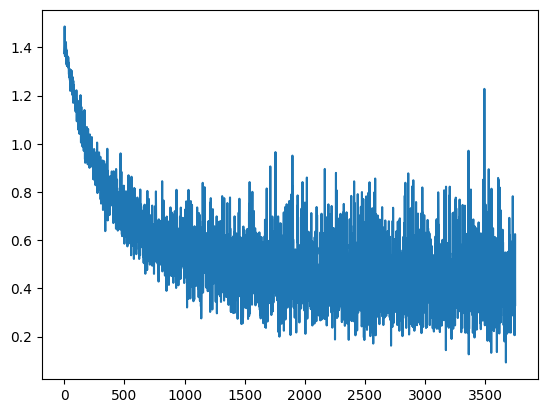

In [29]:
from matplotlib import pyplot as plt
plt.plot(batch_losses)

### 15.10.4 Evaluation

![](https://raw.githubusercontent.com/dvgodoy/assets/main/PyTorchInPractice/images/ch0/model_step5.png)

Losses are looking ok-ish, how about actual metrics? Let's use HuggingFace's `evaluate` package once again. This time, though, we're loading each metric (precision, recall, and accuracy) separately because we're dealing with a multi-class classification task, and this doesn't sit well with the `combine()` method (at the time of writing). Just run the code below as is to create evaluators for the three metrics:

In [30]:
import evaluate

metric1 = evaluate.load('precision', average=None)
metric2 = evaluate.load('recall', average=None)
metric3 = evaluate.load('accuracy')

Write an evaluation loop that goes over the mini-batches in the test data pipe and:
- tokenizes the sentences
- encode the sentences (convert their tokens into token ids)
- retrieves their corresponding bags of embeddings
- get predictions from the model (logits)
- gets the most-likely class from the logits
- adds both predicted classes and labels to the metrics objects we've just created using their `add_batch()` method

In [31]:
model.eval()

for batch in dataloaders['test']:
    # Unpack your batch (it has labels and sentences)
    # Tokenize and encode the sentences, and compute their bags of embeddings
    # write your code here
    labels, sentences = batch['topic'], batch['news']
    tokens = tokenize_batch(sentences)
    token_ids = encode_batch(vec.key_to_index, tokens, padding=False)
    embeddings = get_bag_of_embeddings(embedding, token_ids)
        
    embeddings = embeddings.to(device)
    labels = labels.to(device)

    # write your code here
    predictions = model(embeddings)

    # write your code here
    pred_class = predictions.argmax(dim=1)
    
    pred_class = pred_class.tolist()
    labels = labels.tolist()

    metric1.add_batch(references=labels, predictions=pred_class)
    metric2.add_batch(references=labels, predictions=pred_class)
    metric3.add_batch(references=labels, predictions=pred_class)

Finally, call each metric's `compute()` object to get the results. Just run the code below as is to visualize the resulting metrics:

In [32]:
metric1.compute(average=None), metric2.compute(average=None), metric3.compute()

({'precision': array([0.87607296, 0.9213198 , 0.80229525, 0.81990265])},
 {'recall': array([0.85947368, 0.95526316, 0.80947368, 0.79789474])},
 {'accuracy': 0.8555263157894737})

A single linear layer can achieve roughly 85% accuracy, which isn't bad at all! Even old, traditional, embeddings such as GloVe can lead to pretty decent results.